### Instalacja potrzebnych bibliotek

In [1]:
#pip install ipywidgets #interaktywne widżety HTML dla notebooków Jupyter i jądra IPython

In [2]:
#pip install keras 

In [3]:
#pip install tensorflow

### Importowanie wymaganych bibliotek

In [4]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense # głęboko połączona warstwa przekazująca neurony dalej (batch, size)
from tensorflow.keras.layers import Flatten # "spłaszcza" dane wejściowe, przekształca w 1wymiarową tablicę; nie wpływa na wielkość partii
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization #warstwa normalizująca dane wejściowe
from tensorflow.keras.layers import Dropout # odrzuca część losową informacji, gdy sieć wyciąga za dużo informacji
from tensorflow.keras.layers import LSTM # warstwa pamięci długookresowej (sztuczna rekurencyjna architektura sieci neuronowej RNN)
from tensorflow.keras.models import Model # grupuje warstwy w obiekt z funkacjami uczenia i wnioskowania
from tensorflow.keras.models import Sequential, load_model # do zaczytywania i wczytywania modelu
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display # tworzymy obiekt audio 
import ipywidgets as widgets
from ipywidgets import interact, interact_manual # automatyczne tworzenie kontrolek interfejsu użytkownika  (user interface UI)
from ipywidgets import interactive

from sklearn.model_selection import train_test_split # dzielenie tablic lub macierzy na losowe podzbioru trenowania i testowania. 
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from sklearn.metrics import r2_score # R2- współczynnik determinacji; funkcja oceny regresji 
from sklearn.metrics import mean_absolute_error #MAE oraz MSE (błędy)
from sklearn.metrics import mean_squared_error

##### Import bibliotek do stworzenia sieci LSTM

In [5]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler # przekształcanie cech skalując każdą z cech do określonego zakresu
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping # przerywa trenowanie, gdy monitorowana metryka przestanie się poprawiać; 
                                          # estymator ten skaluje i tłumaczy każdą cechę indywidualnie tak, że znajduje się ona w zadanym zakresie na zbiorze uczącym (np. między 0 a 1)

### Wczytanie bazy

In [6]:
# katalog z plikiem powinien się znajdować w tym samym folderze, co obecnie odpalony plik
data = pd.read_csv('./data/eth_v_d.csv')

### Podzial na zbiór treningowy i testowy

In [7]:
# pierwsza liczba oznacza ilość wierszy, natomiast druga ilość kolumn w zbiorze danych
print(data.shape)

(2072, 5)


In [8]:
# zbiór treningowy
ratio = 0.6  # współczynnik proporcji wymiarów (0.6 w stosunku do całego zbioru danych)
N = int(len(data)*ratio)   # liczba próbek na klasę
train_df, test_df = data[:N], data[N:]   # przypisanie próbek do zmiennych
print(train_df.shape)

(1243, 5)


In [9]:
# zbiór testowy
ratio = 0.5
N = int(len(data)*ratio)
test_df, val_df = test_df[:N], test_df[N:]
print(test_df.shape)

(829, 5)


In [10]:
# funkcja oblicza podsumowanie statystyk odnoszących się do kolumny DataFrame. 
# ta funkcja podaje wartości średnie, standardowe i odstęp międzykwartylowy.
train_df.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie
count,1243.000000,1243.000000,1243.000000,1243.000000
mean,209.190909,218.160156,198.442360,209.302651
std,272.820407,285.257570,257.265208,272.770696
min,0.420000,0.471900,0.411000,0.420000
25%,10.075000,10.565000,9.655000,10.090000
50%,50.090000,52.220000,48.450000,50.250000
75%,313.885000,324.735000,300.190000,313.885000
max,1385.020000,1422.860000,1271.070000,1385.020000


In [11]:
# zapewnia obliczania w oknie kroczącym. 
# windows = rozmiar ruchomego okna, jest to liczba obserwacji użytych do obliczenia statystyki. 
# każde okno będzie miało stały rozmiar.
rolling = data.rolling(window=7)

In [12]:
# definiujemy nasz y, który chcemy przewidzieć; trenujemy model tylko na "Zamkniecie"
data_roll = pd.DataFrame()
data_roll['Zamkniecie']=train_df['Zamkniecie']

In [13]:
@widgets.interact_manual(lw=(1, 100))  #wstawia suwak do ręcznego wywoływania funkcji. Nie ma potrzeby uruchamiać za każdym razem kod, gdy zmieniamy wartość. 
def plot(lw):
  rolling = data.rolling(window=lw, center=True)
  data_roll = pd.DataFrame()
 
  data_roll['Zamkniecie']=data['Zamkniecie']
  data_roll['7 days rolling_mean(srednia kroczaca)']=data_roll['Zamkniecie'].rolling(lw, min_periods=1).mean()
  ax = data_roll.plot(style=['-', '--'], rot=90, figsize=(20, 10)) #odpowiada za rozmiar wykresu, oraz styl linii
  ax.lines[0].set_alpha(0.3)   #zmienia przeźroczystość linii wskazującej "Zamknięcie".

interactive(children=(IntSlider(value=50, description='lw', min=1), Button(description='Run Interact', style=B…

### Przygotowanie danych do uczenia na sieci LSTM (zmiana wymiarow macierzy, by model zaczal obrabiac dane)

In [14]:
zmienna_przewidywana = "Zamkniecie"

def prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamiana typu na float
  dataset = np.reshape(dataset, (-1, 1)) #przekształcamy tablicę; wynikowa tablica ma tylko 1 kolumnę
  scaler = MinMaxScaler(feature_range=(0, 1)) #skalowanie zmiennych do postaci (0,1)
  dataset = scaler.fit_transform(dataset) # wszystkie inne wartości są liniowo skalowane między tymi wartościami

#dzielimy uporządkowany zestaw danych do trenowania i testowania. Oblicza index punktu podziału i rozdziela dane na zestawy szkoleniowe z test. obserwacji, których można użyć do trenowania modelu, pozostawiając pozostałe do przetestowania
  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler

#uruchamiany tą funkcję z wyżej, przygotowanie modelu pod LSTM
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8) #scaler - skaluje dane do zakresu 0, 1 (tak zwana normalizacja)

In [15]:
# look_back- liczba poprzednich kroków czasowych, które mają być użyte jako zmienne wejściowe do przewidywania następnego okresu czasu, w tym przypadku domyślnie 1.
# scaler- skaluje dane do zakresu 0,1 (normalizacja)
# tworzenie back(ów); konwertujemy tablicę wartości na macierz zestawu danych
def create_dataset_lstm(dataset, look_back=1):   #look_back - wielkość kroku z którą testujemy dataset
    X, Y = [], []
    for i in range(len(dataset)-look_back-1): # żeby nie wyszło poza zasięg
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

#używamy funkcji by przygotować zestaw i przetestować zestawy danych do modelowania.
look_back = 20 #liczba probek ktora pobieramy, minimalnie jedna próbka, maksymalnie tyle, ile ma ciąg elementów
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

#Zmienia kształt wejścia na próbki, kroki czasowe, cechy,
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Uczenie modelu

In [16]:
#Tworzymy i dopasowujemy model LSTM (zmiana batch_size). W poniższym modelu jest jedno wejście w warstwie wejściowej
# i 10 neuronów w warstwie ukrytej. Warstwa wyjściowa przewiduje wartości
def lstm_model(X_train, Y_train, X_test, Y_test, batch_size=20):
  model = Sequential()  #liniowy stos warstw
  model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2)) 
  model.add(Dense(5))
# definiujemy w czym będziemy wyrażać naszą jakość uczenia
  model.compile(loss='mean_squared_error', optimizer='adam') #definiujemy w czym będziemy wyrażać naszą jakośc uczenia

# epochs - Funkcja aktywacji powtarzana jest 5 razy
  history = model.fit(X_train, Y_train, epochs=5, batch_size=10, validation_data=(X_test, Y_test), 
                      # przerwij trenowanie, gdy monitorowana metryka przestanie się poprawiać
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
  return model



## Ewaluacja modelu

In [17]:
#ewaluacja modelu
def evaluation_model(model,X_train, X_test, Y_train, testing=False):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))  # zmienia shape na odwrotny (odwrócenie macierzy) nie w sposób ciągły (1 pod 2)
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  
#wykonaj prognozy
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

#odwróć prognozy, przy obliczaniu błędu przekonwertujemy dane na tą samą jednostkę.  
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])

#oblicz średni kwadrat błędu
  _mean_absolute_error = mean_absolute_error(Y_train[0], train_predict[:,0])   #jak mamy listę 13 elementów, to wstawiając [3,:] pobierze od 3 do 13 elementu
  _mean_squared_error = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
  print('Train Mean Absolute Error:', _mean_absolute_error)
  print('Train Root Mean Squared Error:',_mean_squared_error)
  if testing:
    return Y_train, train_predict, _mean_absolute_error, _mean_squared_error
  return Y_train, train_predict



In [18]:
def a():
    return 1, 2, (10, 20)

x,y, error = a()
print(a())
print(x,y, error)

# 1 to nasz x- Y_train, 2 nasz y- train_predict  a (10-_mean_absolute_error, 20- _mean_squared_error) nasze dołożone errory (patrz analogicznie linijkę wyżej)

(1, 2, (10, 20))
1 2 (10, 20)


In [19]:
#Model się uczy!
history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10)

# loss to funkcja straty na zbiorze treningowym
# val_loss to funkcja straty na zbiorze walidacyjnym (im mniejsza tym lepiej)

# widzimy że z każdą kolejną epoką te dwa błędy są coraz mniejsze- zatem model dobrze się uczy. 
# im mniejsze błędy (bliższe 0- tym lepiej)

Epoch 1/5
98/98 [==============================] - 3s 15ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 2/5
98/98 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0029
Epoch 3/5
98/98 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 4/5
98/98 [==============================] - 0s 2ms/step - loss: 9.3353e-04 - val_loss: 0.0014
Epoch 5/5
98/98 [==============================] - 0s 2ms/step - loss: 7.4600e-04 - val_loss: 0.0030


In [20]:
# zapisujemy model sieci neuronowej w formacie JSON
model_json = history.to_json()  #zapisanie modelu history do JSON
with open("model.json", "w") as json_file:  #utwórz plik model.json w trybie edycji i zatrzymaj w zmiennej json_file
    json_file.write(model_json)
# zapisanie wagi z modelu za pomocą funkcji save.weights. 
history.save_weights("model.h5")  #wagi są zapisywane w pliku model.h5 w katalogu lokalnym.
print("Saved model to disk")  #komentarz udanej operacji

Saved model to disk


In [21]:

evaluation_model(history,X_train, X_test, Y_train)

Train Mean Absolute Error: 42.671274480174866
Train Root Mean Squared Error: 60.13363736706092


(array([[1.14000005e+00, 1.29999994e+00, 1.17999998e+00, 1.32000006e+00,
         1.30999992e+00, 1.36000000e+00, 1.14000005e+00, 1.23000005e+00,
         1.35000001e+00, 1.36999998e+00, 1.34000003e+00, 1.27999997e+00,
         1.26000000e+00, 1.21000009e+00, 1.19000012e+00, 9.24199986e-01,
         1.15000003e+00, 8.85599978e-01, 9.54999996e-01, 9.50000004e-01,
         9.36300016e-01, 8.74999970e-01, 8.52300013e-01, 8.90000025e-01,
         8.87099999e-01, 9.41199990e-01, 8.05900005e-01, 9.09999991e-01,
         8.00000016e-01, 6.82299978e-01, 7.70299958e-01, 7.00800003e-01,
         6.00000032e-01, 6.81599936e-01, 7.13700012e-01, 6.54799985e-01,
         6.64699990e-01, 6.79599988e-01, 6.09500008e-01, 6.07799992e-01,
         6.51099980e-01, 6.00000032e-01, 6.19999998e-01, 6.35200008e-01,
         6.35099991e-01, 5.99300030e-01, 6.29999981e-01, 6.01700008e-01,
         5.00000000e-01, 5.60000019e-01, 5.24999958e-01, 5.23000009e-01,
         5.04999992e-01, 5.00000000e-01, 4.39999981

In [22]:
Y_train, train_predict = evaluation_model(history,X_train, X_test, Y_train)

Train Mean Absolute Error: 42.671274480174866
Train Root Mean Squared Error: 60.13363736706092


In [23]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0]) 
  aa=[x for x in range(N)]  # N oznacza liczbę cech w punkcie danych
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual") # gdy . zmienimy na * to będziemy mieli zamiast . -> *
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()  # dostosuj dopełnienie między polamy pomocniczymi i wokół nich
  sns.despine(top=True) # usuwamy grzbiet
  plt.subplots_adjust(left=0.07)  # położenie lewej krawędzi wykresu
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)  # rozmiar czcionki dla time step 15
  plt.legend(fontsize=15)  # rozmiar czcionki elementów legendy
  plt.show();  # uruchamiamy pętle zdarzeń, wyszukujemy wszystkie aktywne obiekty figur i otwieramy jedno lub więcej inteaktywnych okien.



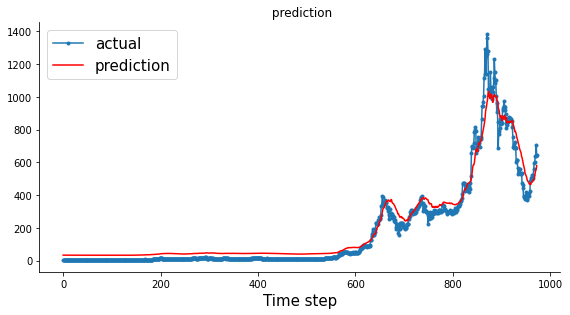

In [24]:
# Na wykresie dane nie są znormalizowane
visualization(Y_train, train_predict) # niebieska- z csv wiersze i do nich wartości z pliku excel (na podstawie ratio nie cale 2849 tylko 0.6 z tego); czerwone- dla poszczegolnych wierszy błędy; model dobrze się uczy

## Zmieniamy wielkosc batch, by zobaczyc jaki wplyw ma ta zmienna na wyniki

In [25]:
# <odswiezam dane>, gdyz wymiary danych testowych i treningowych przestaja sie zgadac
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)

def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 3 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)
print(X_test)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

[[0.46750686 0.4893543  0.4913838 ]
 [0.4893543  0.4913838  0.48360538]
 [0.4913838  0.48360538 0.48366314]
 [0.48360538 0.48366314 0.49434495]
 [0.48366314 0.49434495 0.55199337]
 [0.49434495 0.55199337 0.56918246]
 [0.55199337 0.56918246 0.5812581 ]
 [0.56918246 0.5812581  0.56560737]
 [0.5812581  0.56560737 0.54112375]
 [0.56560737 0.54112375 0.5390727 ]
 [0.54112375 0.5390727  0.53895706]
 [0.5390727  0.53895706 0.5315542 ]
 [0.53895706 0.5315542  0.48300594]
 [0.5315542  0.48300594 0.4867471 ]
 [0.48300594 0.4867471  0.52492416]
 [0.4867471  0.52492416 0.5261303 ]
 [0.52492416 0.5261303  0.5115629 ]
 [0.5261303  0.5115629  0.5010978 ]
 [0.5115629  0.5010978  0.48985267]
 [0.5010978  0.48985267 0.49668497]
 [0.48985267 0.49668497 0.49802107]
 [0.49668497 0.49802107 0.51892966]
 [0.49802107 0.51892966 0.50141555]
 [0.51892966 0.50141555 0.46825078]
 [0.50141555 0.46825078 0.43006647]
 [0.46825078 0.43006647 0.42464975]
 [0.43006647 0.42464975 0.41950744]
 [0.42464975 0.41950744 0.43

In [26]:
# wielkosc batchu [10, 20, 50]
batch_start, batch_end = 30, 40 # od do
look_backs = [3,10,30] # takie look backi sprawdzamy i potem do nich mozemy wykresy zrobic


error_look_back = {}
for look_back in look_backs:
  MAEs = []
  MSEs = []
  Y_trains = []
  train_predicts = []

  X_train, Y_train = create_dataset_lstm(train, look_back)
  X_test, Y_test = create_dataset_lstm(test, look_back)
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  for batch in range(batch_start, batch_end):
    print(f'-------------------------------{batch}--------------------------')
    history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=batch)
    tmp_Y_train, tmp_train_predict, MAE, MSE  = evaluation_model(history,X_train, X_test, Y_train, testing=True)
    
    MAEs.append(MAE)
    MSEs.append(MSE)
    Y_trains.append(tmp_Y_train)
    train_predicts.append(tmp_train_predict)
  error_look_back[look_back] = {"MAE":MAEs, "MSE":MSEs, "Y_trains": Y_trains, "train_predicts": train_predicts}



-------------------------------30--------------------------
Epoch 1/5
100/100 [==============================] - 2s 5ms/step - loss: 0.0046 - val_loss: 0.0186
Epoch 2/5
100/100 [==============================] - 0s 1ms/step - loss: 0.0166 - val_loss: 0.0099
Epoch 3/5
100/100 [==============================] - 0s 1ms/step - loss: 0.0135 - val_loss: 0.0042
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0014
Epoch 5/5
100/100 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 4.5615e-04
Train Mean Absolute Error: 56.54924715216551
Train Root Mean Squared Error: 65.32147151449567
-------------------------------31--------------------------
Epoch 1/5
100/100 [==============================] - 2s 5ms/step - loss: 0.0041 - val_loss: 0.0184
Epoch 2/5
100/100 [==============================] - 0s 1ms/step - loss: 0.0161 - val_loss: 0.0102
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0112 - val_los

Epoch 4/5
99/99 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 5.2262e-04
Epoch 5/5
99/99 [==============================] - 0s 2ms/step - loss: 7.0392e-04 - val_loss: 6.5071e-04
Train Mean Absolute Error: 40.98023488724682
Train Root Mean Squared Error: 54.43533510110131
-------------------------------33--------------------------
Epoch 1/5
99/99 [==============================] - 2s 5ms/step - loss: 0.0036 - val_loss: 0.0077
Epoch 2/5
99/99 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0018
Epoch 3/5
99/99 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 6.8576e-04
Epoch 4/5
99/99 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 9.6499e-04
Epoch 5/5
99/99 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 5.9525e-04
Train Mean Absolute Error: 33.74317814826827
Train Root Mean Squared Error: 57.22253151439069
-------------------------------34----------------

97/97 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0072
Epoch 2/5
97/97 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0082
Epoch 3/5
97/97 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 4/5
97/97 [==============================] - 0s 1ms/step - loss: 9.0677e-04 - val_loss: 0.0034
Epoch 5/5
97/97 [==============================] - 0s 1ms/step - loss: 8.4761e-04 - val_loss: 0.0041
Train Mean Absolute Error: 43.87416122794296
Train Root Mean Squared Error: 76.54027860689146
-------------------------------36--------------------------
Epoch 1/5
97/97 [==============================] - 2s 5ms/step - loss: 0.0022 - val_loss: 0.0089
Epoch 2/5
97/97 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 3/5
97/97 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 4/5
97/97 [==============================] - 0s 2ms/step - loss: 0

#### Wraz ze wzrostem batch'a, pogorszaja sie na wyniki - MAE i MSE idealnie powinny rownac sie zero, wiec generalnie im mniejsze ich wartosci, tym model uwazamy za lepszy

In [27]:
# wyświetlenie liczby kolumn i wierszy; 2849:1346= 2,1 , a więc 20% (a wcześniej ratio 0.8), więc tak przyjął; model treningowy z predykcją (czerwona linia na wykresie)
train_predict.shape

(973, 5)

In [28]:
error_look_back[3]["MSE"]

[65.32147151449567,
 31.948721089647922,
 33.15604865315491,
 48.94749380318166,
 68.56140669180377,
 29.750250026043034,
 73.48939310560633,
 40.12143393981535,
 43.34160408896204,
 38.73365583334787]

In [29]:
error_look_back[3]["MAE"]

[56.54924715216551,
 17.48013914604329,
 23.516325487923336,
 41.02988749613517,
 58.763431073414,
 15.712248816619887,
 63.83662258648061,
 31.66594255360155,
 34.03524447250835,
 29.51573133286306]

In [30]:
# wyświetlenie i posortowanie MSE
MSEs.sort()
print(MSEs)

[57.27165789100075, 62.17375551051462, 62.26656211432062, 66.8094854831697, 70.33579027320918, 73.4876754900699, 74.21625677142866, 75.41338024730933, 76.54027860689146, 81.35829199111087]


<AxesSubplot:>

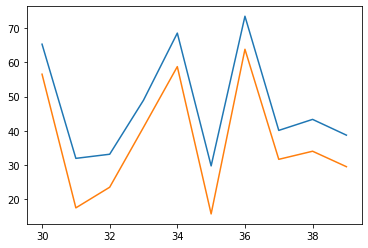

In [31]:
# wykres kreśli linię MSE, oraz MAE
look_back_to_check = 3 
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MAE"])


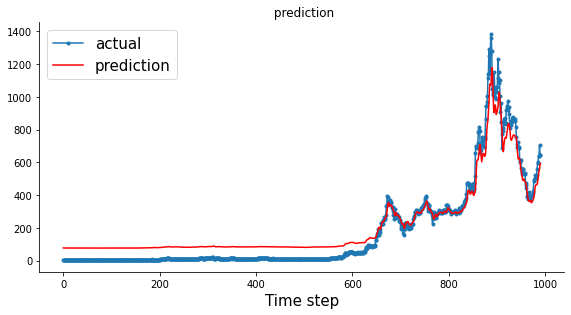

In [32]:
batch_index = 6 # to znaczy batch_start (bedzie tyle indexow ile jest od batch_start do batch_end)
look_back_to_check = 3 #jak to wyrzucimy, to tez bedzie dzialac
visualization(Y_train = error_look_back[look_back_to_check]["Y_trains"][batch_index], train_predict = error_look_back[look_back_to_check]["train_predicts"][batch_index])

In [33]:
error_look_back[3]["Y_trains"][0]

array([[1.20000010e+00, 9.90000017e-01, 1.28999995e+00, 1.88000008e+00,
        1.79000007e+00, 1.79000007e+00, 1.36999998e+00, 1.29999994e+00,
        1.36000000e+00, 1.24000004e+00, 1.52000005e+00, 1.44000002e+00,
        1.40000009e+00, 1.35000001e+00, 1.24000004e+00, 1.26999999e+00,
        1.17999998e+00, 1.14000005e+00, 1.29999994e+00, 1.17999998e+00,
        1.32000006e+00, 1.30999992e+00, 1.36000000e+00, 1.14000005e+00,
        1.23000005e+00, 1.35000001e+00, 1.36999998e+00, 1.34000003e+00,
        1.27999997e+00, 1.26000000e+00, 1.21000009e+00, 1.19000012e+00,
        9.24199986e-01, 1.15000003e+00, 8.85599978e-01, 9.54999996e-01,
        9.50000004e-01, 9.36300016e-01, 8.74999970e-01, 8.52300013e-01,
        8.90000025e-01, 8.87099999e-01, 9.41199990e-01, 8.05900005e-01,
        9.09999991e-01, 8.00000016e-01, 6.82299978e-01, 7.70299958e-01,
        7.00800003e-01, 6.00000032e-01, 6.81599936e-01, 7.13700012e-01,
        6.54799985e-01, 6.64699990e-01, 6.79599988e-01, 6.095000